In [86]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
import albumentations as A
from tqdm import tqdm
import segmentation_models_pytorch as smp

In [87]:
if torch.cuda.is_available():
    print("GPU is available!")
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("GPU is not available.")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

GPU is not available.


In [88]:
images =[]
masks =[]
no_file=[]
img_path="data/image/water_body_{}.jpg"
mask_path="data/mask/water_body_{}.jpg"
for i in range(1,8161):
    try:
        im = plt.imread(img_path.format(i))
        ma = plt.imread(mask_path.format(i))
        im = cv2.resize(im,(128,128),interpolation=cv2.INTER_CUBIC)
        ma = cv2.resize(ma,(128,128),interpolation=cv2.INTER_CUBIC)
        grayimg = ma[:,:,0]*0.2989+ma[:,:,1]*0.5870+ma[:,:,2]*0.1140
        images.append(im)
        masks.append(grayimg)
    except FileNotFoundError:
        no_file.append(i)

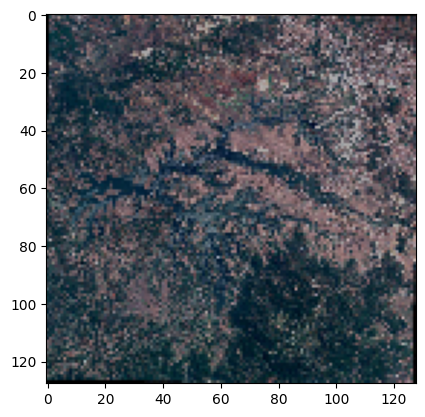

In [89]:
plt.imshow(images[0])

In [90]:
masks[0].shape

(128, 128)

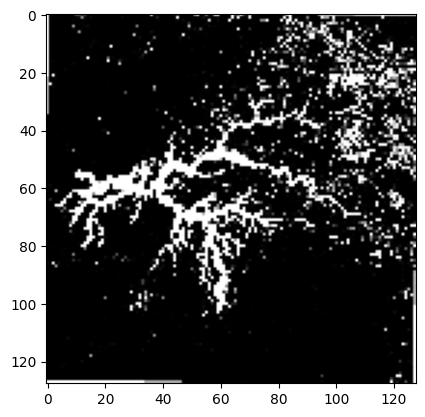

In [91]:
plt.imshow(masks[0],cmap='gray')

In [92]:
def get_augmentations(image_size = 128, crop_prob = 1):
    return A.Compose([

        A.RandomCrop(width = image_size, height = image_size, p=crop_prob),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.RandomGamma(p=0.25),
    ],p=1)

In [93]:
gimg = get_augmentations()(image = images[0],mask = masks[0])

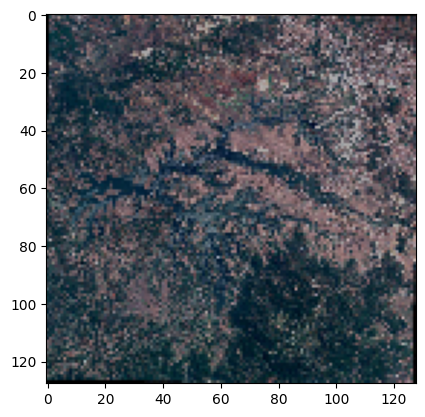

In [94]:
plt.imshow(images[0])

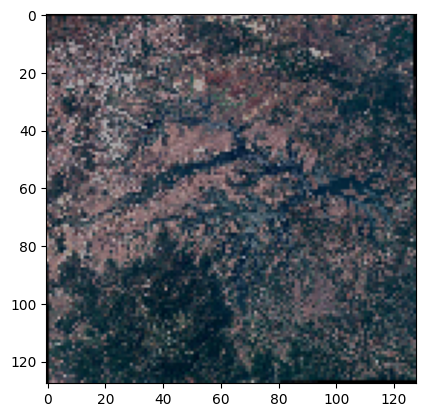

In [95]:
plt.imshow(gimg['image'])

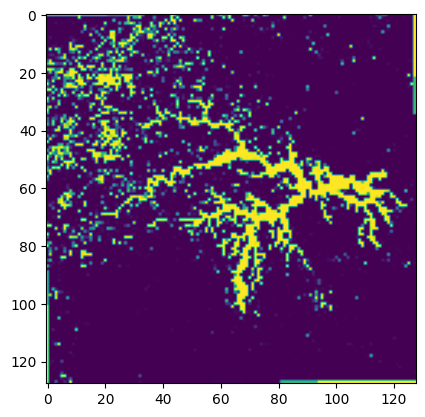

In [96]:
plt.imshow(gimg['mask'])

In [97]:
timgs,tmasks = images.copy(),masks.copy()
for image,mask in tqdm(zip(images,masks)):
    aug = get_augmentations()(image=image,mask=mask)
    timgs.append(aug['image'])
    tmasks.append(aug['mask'])

2238it [00:00, 4379.04it/s]


In [98]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(timgs,tmasks,test_size=0.05,random_state=42)

In [99]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [100]:
def dice_score(pred, target, epsilon=1e-6):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum(dim=(1, 2, 3))
    union = pred.sum(dim=(1, 2, 3)) + target.sum(dim=(1, 2, 3))
    dice = (2. * intersection + epsilon) / (union + epsilon)
    return dice.mean()

def iou_score(pred, target, epsilon=1e-6):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum(dim=(1, 2, 3))
    union = pred.sum(dim=(1, 2, 3)) + target.sum(dim=(1, 2, 3)) - intersection
    iou = (intersection + epsilon) / (union + epsilon)
    return iou.mean()

class SatelliteDataset(Dataset):
    def __init__(self, images, masks, augmentation=None):
        self.images = images
        self.masks = masks
        self.augmentation = augmentation

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]
        
        if self.augmentation:
            augmented = self.augmentation(image=image, mask=mask)
            image, mask = augmented['image'], augmented['mask']
        
        # Transform to tensor and add channel dimension to mask
        return torch.from_numpy(image.transpose(2, 0, 1)).float(), torch.from_numpy(mask).float().unsqueeze(0)

In [101]:
train_dataset = SatelliteDataset(X_train, y_train, augmentation=get_augmentations())
test_dataset = SatelliteDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [102]:
model = smp.Unet(encoder_name="vgg16", encoder_weights="imagenet", in_channels=3, classes=1)
# Move the model to the configured device
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = smp.losses.DiceLoss(mode='binary')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/gaurabsapkota/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:23<00:00, 23.9MB/s] 


In [103]:
train_losses, val_losses, train_dice_scores, val_dice_scores, train_iou_scores, val_iou_scores = [], [], [], [], [], []

for epoch in range(50):  # Adjust the number of epochs as necessary
    model.train()
    total_loss = 0
    for images, masks in tqdm(train_loader):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_func(outputs, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss / len(train_loader))
    train_dice_scores.append(dice_score(outputs, masks).item())
    train_iou_scores.append(iou_score(outputs, masks).item())

    # Validation phase
    model.eval()
    total_val_loss, val_dice, val_iou = 0, [], []
    with torch.no_grad():
        for images, masks in tqdm(test_loader):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            val_loss = loss_func(outputs, masks)
            total_val_loss += val_loss.item()
            val_dice.append(dice_score(outputs, masks).item())
            val_iou.append(iou_score(outputs, masks).item())
        val_losses.append(total_val_loss / len(test_loader))
        val_dice_scores.append(np.mean(val_dice))
        val_iou_scores.append(np.mean(val_iou))

    print(f'Epoch {epoch}: Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Train Dice: {train_dice_scores[-1] if train_dice_scores else 0}, Val Dice: {val_dice_scores[-1] if val_dice_scores else 0}, Train IoU: {train_iou_scores[-1] if train_iou_scores else 0}, Val IoU: {val_iou_scores[-1] if val_iou_scores else 0}')

100%|██████████| 14/14 [00:17<00:00,  1.25s/it]


Epoch 0: Train Loss: -0.9070962606964255, Val Loss: -0.9741491164479937, Train Dice: 1.9566575288772583, Val Dice: 1.9546476602554321, Train IoU: 66.71562957763672, Val IoU: 91.19854600088937


  7%|▋         | 18/266 [01:10<16:49,  4.07s/it]

In [ ]:
import matplotlib.pyplot as plt

# Plotting training and validation loss
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 2)
plt.plot(train_dice_scores, label='Train Dice Score')
plt.plot(val_dice_scores, label='Validation Dice Score')
plt.title('Dice Score over epochs')
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 3)
plt.plot(train_iou_scores, label='Train IoU Score')
plt.plot(val_iou_scores, label='Validation IoU Score')
plt.title('IoU Score over epochs')
plt.xlabel('Epoch')
plt.ylabel('IoU Score')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Set the model to evaluation mode
model.eval()

# Fetch a batch of data from the test_loader
test_images, test_masks = next(iter(test_loader))

# Move the test images and masks to the configured device
test_images = test_images.to(device)
test_masks = test_masks.to(device)

# Perform inference without calculating gradients
with torch.no_grad():
    predictions = model(test_images)

# Visualize the first few samples from the batch
num_samples = 5  # Adjust this number based on how many samples you want to visualize
fig, axs = plt.subplots(num_samples, 2, figsize=(10, 5 * num_samples))  # Adjust subplot grid for 2 columns instead of 3
for i in range(num_samples):
    true_mask = test_masks[i].cpu().numpy().squeeze()
    pred_mask = torch.sigmoid(predictions[i]).cpu().numpy().squeeze() > 0.5  # Apply sigmoid and threshold

    axs[i, 0].imshow(true_mask, cmap='gray')
    axs[i, 0].set_title('True Mask')
    axs[i, 0].axis('off')

    axs[i, 1].imshow(pred_mask, cmap='gray')
    axs[i, 1].set_title('Predicted Mask')
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()